# Estudo Piloto


## Amostra

Estudo realizado com parte da amostra coletada

50 participantes retirados do banco de dados principal, aqueles com maior numero de atividades, somente corrida de rua ou ciclismo (run, ride);

## Cópia do banco de dados principal

```mysql
$ mysql
mysql> CREATE DATABASE estudo_piloto;

$ mysqldump -u root doutorado | mysql -u root estudo_piloto
```


## Conexão ao banco de dados "estudo_piloto"

In [2]:
# Conecta ao banco de dados "estudo_piloto"

# Instala recursos necessários

#!pip install pymysql

# Importa bibliotecas necessárias

import pymysql
import pandas as pd
from tabulate import tabulate

# Conecta ao banco MySQL

MYSQL_HOST = "rafaelsulino.pro.br"
MYSQL_PORT = 3306
MYSQL_DB = "estudo_piloto"
MYSQL_USER = "root"
MYSQL_PASS = "1qazxmklop0"

conn = pymysql.connect(MYSQL_HOST, user=MYSQL_USER, port=MYSQL_PORT, passwd=MYSQL_PASS, db=MYSQL_DB)
cursor = conn.cursor()
cursor.execute("SELECT VERSION()")

data = cursor.fetchone()
print("Versão do MySQL: %s " % data)

/bin/sh: 1: pip: not found
Versão do MySQL: 5.7.26 


## Limpeza dos dados

In [ ]:
# Limpeza dos dados

# 1. Elimina todos as atividades que não sejam corrida de rua (run) ou ciclismo (ride)

sql_limpa = """
            DELETE FROM atividades
            WHERE tipo NOT IN ("Run", "Ride")
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()
   

In [ ]:
# Elimina todas as atividades com menos de 30 minutos de duração

# (moving_time / 60) > 30 ==> moving_time > 1800

sql_limpa = """
            DELETE FROM atividades
            WHERE moving_time < 1800
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()

In [ ]:
# Elimina todas as atividades sem dados de latitude e longitude

sql_limpa = """
            DELETE FROM atividades
            WHERE latitude_inicio IS NULL
            OR longitude_inicio IS NULL
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()

In [ ]:
# Remover todas as atividades marcadas com "flag" (flagged = 1)

sql_limpa = """
            DELETE FROM atividades
            WHERE flagged = 1
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()

In [ ]:
# Elimina todas as atividades sem frequencia cardiaca

sql_limpa = """
            DELETE FROM atividades
            WHERE average_heartrate IS NULL
            OR average_heartrate = ""
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()

In [ ]:
# Remove todas as atividades sem dados de clima

sql_limpa = """
            DELETE FROM atividades
            WHERE id_atividade NOT IN (SELECT id_atividade FROM clima_atividade_inicio)
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()
    
sql_limpa = """
            DELETE FROM atividades
            WHERE id_atividade NOT IN (SELECT id_atividade FROM clima_atividade_fim)
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()

In [ ]:
# 2. Elimina todos os participantes que não tenham atividade associada (após eliminar atividades indesejadas)

sql_limpa = """
            DELETE FROM participantes
            WHERE id_participante NOT IN
            (
                SELECT id_participante FROM atividades
            )
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()

In [ ]:
# 3. Elimina todos os participantes com inconsistencia nos dados (faltando data de nascimento, massa, estatura, etc)

sql_limpa = """
            DELETE FROM participantes
            WHERE data_nascimento IS NULL
            OR data_nascimento = "0000-00-00"
            OR estatura IS NULL
            OR massa_corporal IS NULL
            OR calc_imc IS NULL
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()

In [ ]:
# 4. Elimina todos os participantes com menos de 18 anos ou mais de 65 anos (critério de inclusão)

sql_limpa = """
            DELETE FROM participantes
            WHERE idade < 18
            OR idade > 65
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()

In [ ]:
# 6. Elimina participantes que não tenham questionário WHOQOL-BREF

sql_limpa = """
            DELETE FROM participantes
            WHERE id_participante NOT IN (
                SELECT id_participante FROM saude_qv
            )
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()

## Remover outliers (valores 1,5x maiores ou menores que o desvio padrão)

Inserir gráfico de quartis

![picture](https://www.statisticshowto.datasciencecentral.com/wp-content/uploads/2012/03/iqr.jpg)

In [ ]:
# 7. Remover outliers 1.5x acima do desvio padrão para massa corporal

sql_limpa = """
            DELETE FROM participantes
            WHERE massa_corporal > 
                (
                SELECT * FROM 
                    (
                    SELECT AVG(massa_corporal)+1.5*STDDEV(massa_corporal) 
                    FROM participantes
                    )
                x)
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()

In [ ]:
# 8. Remover outliers 1.5x acima do desvio padrão para estatura

sql_limpa = """
            DELETE FROM participantes
            WHERE estatura > 
                (
                SELECT * FROM 
                    (
                    SELECT AVG(estatura)+1.5*STDDEV(estatura) 
                    FROM participantes
                    )
                x)
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()

In [ ]:
# 9. Remover outliers 1.5x abaixo do desvio padrão para estatura

sql_limpa = """
            DELETE FROM participantes
            WHERE estatura <
                (
                SELECT * FROM 
                    (
                    SELECT AVG(estatura)-1.5*STDDEV(estatura) 
                    FROM participantes
                    )
                x)
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()

In [ ]:
# 7. Remover outliers 1.5x abaixo do desvio padrão para massa corporal

sql_limpa = """
            DELETE FROM participantes
            WHERE massa_corporal < 
                (
                SELECT * FROM 
                    (
                    SELECT AVG(massa_corporal)-1.5*STDDEV(massa_corporal) 
                    FROM participantes
                    )
                x)
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()

In [ ]:
# 5. Elimina todas as atividades que não tenham participantes associados (após limpeza anterior do item 3)


sql_limpa = """
            DELETE FROM atividades
            WHERE id_participante NOT IN (
                SELECT id_participante FROM participantes
            )
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()

In [ ]:
# Elimina questionários sem participantes associados

sql_limpa = """
            DELETE FROM saude_qv
            WHERE id_participante NOT IN (
                SELECT id_participante FROM participantes
            )
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()

In [ ]:
# Elimina dados de clima sem atividades associadas

sql_limpa = """
            DELETE FROM clima_atividade_inicio
            WHERE id_atividade NOT IN (SELECT id_atividade FROM atividades)
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()
   

sql_limpa = """
            DELETE FROM clima_atividade_fim
            WHERE id_atividade NOT IN (SELECT id_atividade FROM atividades)
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()

## Resumo dos dados após limpeza

## Reduzir a 50 participantes

Eliminar o restante de forma randômica

In [ ]:
# 7. Reduzir a 50 participantes (120 do total menos 50 = eliminar 70 aleatoriamente)


sql_limpa = """
            DELETE FROM participantes
            ORDER BY RAND()
            LIMIT 70
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()

In [ ]:
# Remover atividades excedentes (manter somente dos 50 participantes)

sql_limpa = """
            DELETE FROM atividades
            WHERE id_participante NOT IN (
                SELECT id_participante
                FROM participantes
            )
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()

In [ ]:
# Remover questionários excedentes (manter somente dos 50 participantes)

sql_limpa = """
            DELETE FROM saude_qv
            WHERE id_participante NOT IN (
                SELECT id_participante
                FROM participantes
            )
            """

try:
    cursor.execute(sql_limpa)
    conn.commit()
except:
    conn.rollback()

In [ ]:
!pip install pyprog

# Elimina trackpoints sem atividades associadas

# Foi necessário adicionar um indice secundário para o campo 'id_atividade' na tabela atividades para acelerar o delete.
# (> 300 milhões de registros)

import pyprog

max_count = 38 # número de vezes necessárias para loop de 1 em 1 milhão
count = 0

# inicializa a barra de progresso
prog = pyprog.ProgressBar(" ", "", max_count)
prog.update()

for i in range(max_count):
    
    # atualiza a barra de progresso
    prog.set_stat(count + 1)
    prog.update()
    
    count += 1
    
    sql_limpa = """
                DELETE QUICK FROM trackpoints
                WHERE id_atividade NOT IN (
                    SELECT id_atividade FROM atividades
                )
                LIMIT 1000000          
                """

    try:
        cursor.execute(sql_limpa)
        conn.commit()
    except:
        conn.rollback()
        

 Progress: 100% ################################################## 

## Otimizar banco de dados (após limpeza)

Repetir para cada tabela.

Exemplo:

```
mysql> OPTIMIZE TABLE atividades;
```


##Resumo após limpeza

In [ ]:
# Quantidade de dados após limpeza

sql_amostra = """
                SELECT "participantes" AS tabela, COUNT(*) AS registros FROM estudo_piloto.participantes UNION                         
                SELECT "atividades" AS tabela, COUNT(*) AS registros FROM estudo_piloto.atividades UNION
                SELECT "questionarios" AS tabela, COUNT(*) AS registros FROM estudo_piloto.saude_qv UNION
                SELECT "clima_inicio" AS tabela, COUNT(*) AS registros FROM estudo_piloto.clima_atividade_inicio UNION
                SELECT "clima_fim" AS tabela, COUNT(*) AS registros FROM estudo_piloto.clima_atividade_fim UNION
                SELECT "trackpoints" AS tabela, COUNT(*) AS registros FROM estudo_piloto.trackpoints
                """

cursor.execute(sql_amostra)
result = cursor.fetchall()

df = pd.read_sql(sql_amostra , conn)

df

,tabela,registros
0,participantes,50
1,atividades,22322
2,questionarios,50
3,clima_inicio,10276
4,clima_fim,9291
5,trackpoints,74983375


In [ ]:
pd.options.display.float_format = '{:,.2f}'.format

# Seleção dos participantes

sql_amostra = """
                SELECT id_participante, sexo, estatura, massa_corporal, calc_imc, idade
                FROM participantes
            """

   
result = cursor.fetchall()

# Apresenta o resultado

df = pd.read_sql(sql_amostra , conn)
#print(tabulate(df, headers='keys', tablefmt='psql'))

print("50 participantes selecionados")

df


50 participantes selecionados


,id_participante,sexo,estatura,massa_corporal,calc_imc,idade
0,39054988,F,162.00,79.00,30.00,25
1,324247,M,177.00,73.00,23.00,52
2,36266311,M,170.00,67.00,23.00,27
3,26243656,M,180.00,93.00,29.00,55
4,14211154,M,185.00,102.00,30.00,47
5,1240758,M,182.00,77.00,23.00,33
6,31162979,M,182.00,84.00,25.00,38
7,14687184,M,172.00,60.00,20.00,26
8,8388765,M,181.00,87.00,27.00,31
9,3020640,M,186.00,77.00,22.00,49


In [ ]:
# Estatística descritiva

pd.options.display.float_format = '{:,.2f}'.format

#df.dtypes
df.idade = df.idade.astype(int) #converte idade em inteiros

descritiva = df.describe()

print("Estatística descritiva da amostra")
descritiva

Estatística descritiva da amostra


,estatura,massa_corporal,calc_imc,idade
count,50.00,50.00,50.00,50.00
mean,176.60,77.76,24.84,38.76
std,6.77,11.36,2.68,9.23
min,162.00,60.00,20.00,21.00
25%,170.50,70.00,22.25,32.25
50%,177.50,78.00,25.00,37.00
75%,181.00,85.50,27.00,44.50
max,193.00,102.00,30.00,58.00


Apresentação de dados (gráficos com Matplotlib)

Exemplo de uso da biblioteca Matplotlib para produzir gráficos


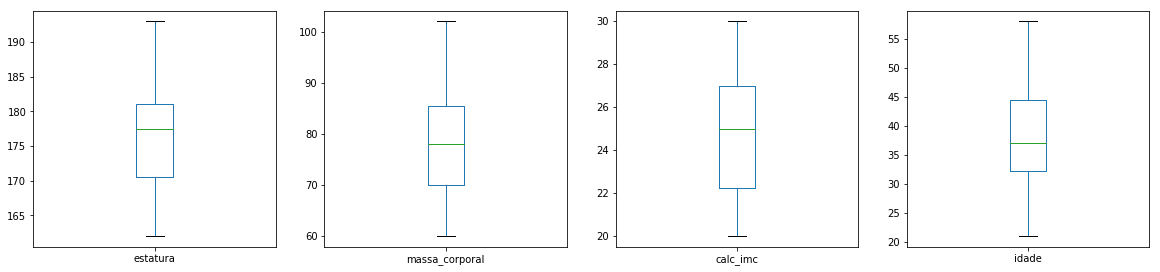

In [ ]:
# Aqui um exemplo de utilização do matplotlib para produzir gráficos

%matplotlib inline
import matplotlib.pyplot as plt

# MATPLOTLIB: Histograma (univariado)
df.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=[20,20])
print("Exemplo de uso da biblioteca Matplotlib para produzir gráficos")
plt.show()

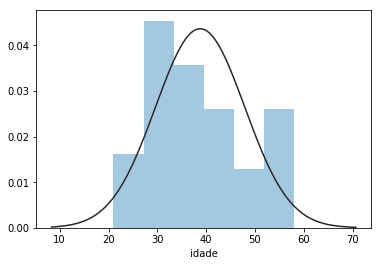

In [ ]:
# Histograma com Seaborn (idade)

import seaborn as sns
from scipy import stats

sns.distplot(df['idade'], fit=stats.norm, kde=False)

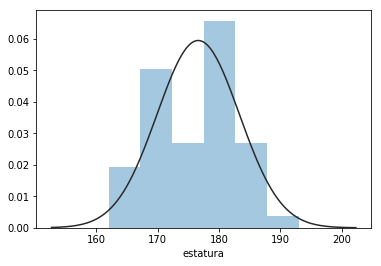

In [ ]:
# Histograma com Seaborn (estatura)

sns.distplot(df['estatura'], fit=stats.norm, kde=False)

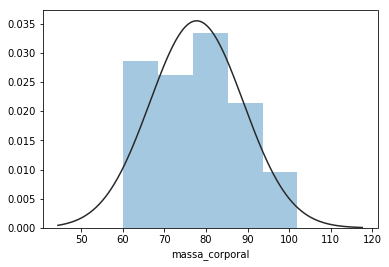

In [ ]:
# Histograma com Seaborn (massa corporal)

sns.distplot(df['massa_corporal'], fit=stats.norm, kde=False)

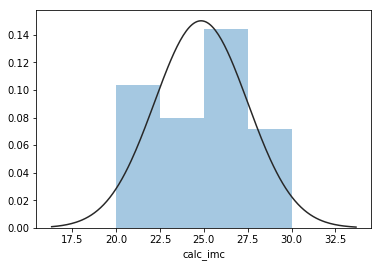

In [ ]:
# Histograma com Seaborn (imc)

sns.distplot(df['calc_imc'], fit=stats.norm, kde=False)

# Perguntas, exploração dos dados



## Zonas de intensidade

Determinar um parâmetro de esforço (zonas de esforço para classificação), de modo a viabilizar a investigação de diversos fatores relacionados ao esforço realizado pelo participante da pesquisa. Como tenho a data de nascimento do participante, as faixas de esforço podem ser calculadas de acordo com a frequência cardíaca máxima estimada para a idade (idade do participante na data em que a atividade foi realizada)

##1. Zonas de intensidade

Referência ACSM

| Intensity               | % FCmax |METs|
|-------------------------|:-------:|-------:|
| very light              |   < 57  | 
| light                   |  57-63  |
| moderate                |  64-76  |
| vigorous                |  77-95  |
| near-maximal to maximal |   > 95  |

tempo de duração x esforço

distância x esforço

velocidade média x esforço

...


In [6]:
sql_zonas = """
            SELECT (zona_fc_predominante) as intensidade, COUNT(*) AS atividades
            FROM atividades
            WHERE zona_fc_predominante IS NOT NULL
            AND zona_fc_predominante <> ""
            GROUP BY zona_fc_predominante
            """

cursor.execute(sql_zonas)
result = cursor.fetchall()

df = pd.read_sql(sql_zonas , conn)

df


,intensidade,atividades
0,Z1,548
1,Z2,555
2,Z3,3382
3,Z4,7536
4,Z5,296


## Desempenho

Identificar o aumento ou redução da performance em um histórico de atividades do participante (período de 1 ano?), e investigar possíveis causas por meio das diversas variáveis coletadas, tanto com relação ao que contribuiu para melhora na performance quanto na perda de performance.


## Clima x desempenho

Identificar a influência do clima, por meio de variáveis isoladas ou combinadas (temperatura, umidade do ar, velocidade do vento, etc) no desempenho do participante, frequência de atividades, etc. Existem índices de conforto térmico que podem ser utilizados para determinar as faixas de classificação (muito frio, frio, moderado, quente, muito quente, etc), dessa forma é possível relacionar variáveis de desempenho e qualidade de vida com tal classificação.



## Variação nas condições climáticas

Identificar e comparar participantes que realizam suas atividades em condições climáticas mais variadas com os que praticam em condições mais constantes.



## Variações no terreno

Do mesmo modo, identificar e comparar participantes que realizar as atividades variando o tipo de terreno (subidas, descidas) com aqueles que praticam as atividades em terrenos mais constantes (sempre plano por exemplo).



## Direção do vento x direção do percurso

Identificar a predominância da direção do vento durante uma determinada atividade, verificando o quanto coincide com a direção do percurso, de modo a investigar o imacto de correr ou pedalar contra ou a favor do vento no desempenho do participante.



## Cálculo da direção entre duas coordenadas (bearing)

Converte em radianos:

$$lat_{1} = pontoA \times \frac{\pi}{180}$$

$$
lat_{2} = pontoB \times \frac{\pi}{180}
$$


Diferença entre as duas coordenadas:
$$
\Delta L= (pontoB - pontoA) \times \frac{\pi}{180}
$$

Vetores:
$$
x = \sin(\Delta L) \times \cos(lat_{2})
$$

$$
y = \cos(lat_{1}) \times \sin(lat_{2}) - \sin(lat_{1}) \times \cos(lat_{2}) \times \cos(\Delta L)
$$

Bearing (direção em ângulo):

$$
\theta=atan2(x,y)
$$



In [32]:
#from JupyterLab demo notebook November 2, 2016
from IPython.display import Latex
Latex('''Converte em radianos:

$$lat_{1} = pontoA \\times \\frac{\pi}{180}$$


$$lat_{2} = pontoB \\times \\frac{\pi}{180}$$

 
Diferença entre as duas coordenadas:

$$
\Delta L= (pontoB - pontoA) \\times \\frac{\pi}{180}
$$

Vetores:
$$
x = \sin(\Delta L) \\times \cos(lat_{2})
$$

$$
y = \cos(lat_{1}) \\times \sin(lat_{2}) - \sin(lat_{1}) \\times \cos(lat_{2}) \\times \cos(\Delta L)
$$

Bearing (direção em ângulo):

$$
\\theta=atan2(x,y)
$$ 
''')

<IPython.core.display.Latex object>

## Gráfico tipo "windrose"

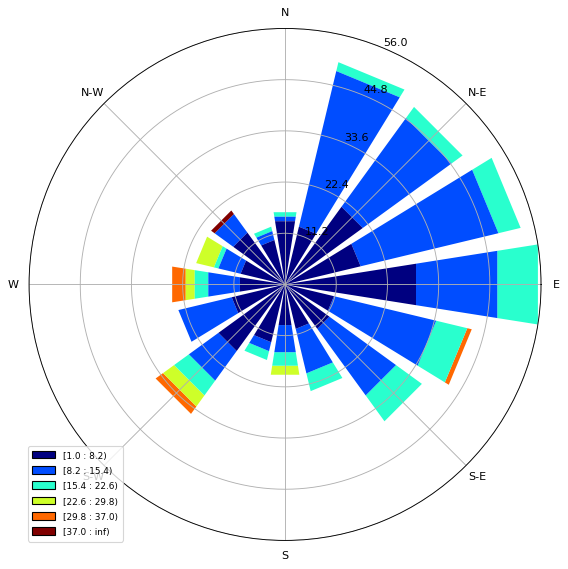

In [10]:
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
from numpy.random import random
from numpy import arange
import pymysql
import pandas as pd
import warnings

## --------------------------------------------------------------------------------------------------
## *** Desabilita warnings ***
## --------------------------------------------------------------------------------------------------

warnings.filterwarnings('ignore')



MYSQL_HOST="rafaelsulino.pro.br"
MYSQL_PORT=3306
MYSQL_DB="doutorado"
MYSQL_USER="root"
MYSQL_PASS="1qazxmklop0"

conn = pymysql.connect(MYSQL_HOST, user=MYSQL_USER, port=MYSQL_PORT, passwd=MYSQL_PASS, db=MYSQL_DB)
cursor = conn.cursor()
cursor.execute("SELECT VERSION()")

data = cursor.fetchone()
#print ("Database version : %s " % data)


sql_amostra = """
                SELECT velocidade_vento, dir_vento_graus 
                FROM clima_atividade_inicio
                LIMIT 500
                """

#cursor.execute(sql_amostra)
result = cursor.fetchall()

df = pd.read_sql(sql_amostra, conn)

ws = df["velocidade_vento"].tolist()
wd = df["dir_vento_graus"].tolist()

#Create wind speed and direction variables
#ws = random(500)*6
#wd = random(500)*360


#A quick way to create new windrose axes...
def new_axes():
    fig = plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='w')
    rect = [0.1, 0.1, 0.8, 0.8]
    ax = WindroseAxes(fig, rect)
    fig.add_axes(ax)
    return ax

#...and adjust the legend box
def set_legend(ax):
    l = ax.legend(borderaxespad=-0.10)
    plt.setp(l.get_texts(), fontsize=8)

# A stacked histogram with normed (displayed in percent) results :

ax = new_axes()
#ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
ax.bar(wd, ws)
set_legend(ax)

## FC x variabilidade do terreno

Investigar a relação entre subidas e descidas acumuladas (variabilidade do terreno) no comportamento da frequÊncia cardíaca (FC máxima, FC média e recuperação da FC após uma subida, por exemplo).



## Influência no sexo

Identificar se variáveis como clima, variabilidade do terreno, etc influenciam de forma diferente no esforço e desempenho do participante, de acordo com o sexo (masculino ou feminino).



## Influência na faixa etária

Identificar se variáveis como clima, variabilidade do terreno, etc influenciam de forma diferente no esforço e desempenho do participante, de acordo com a faixa etária.



## Qualidade de vida

Relacionar o score do questionário WHOQOL-Bref (qualidade de vida) com os hábitos de prática de atividade física do participante. O WHOQOL-Bref apresenta 4 domínios (físico, psicológico, relações pessoais e ambiente), possibilitando relacionar diversas variáveis coletadas com cada um dos domínios relacionados à qualidade de vida.



## Hábito de aquecimento

Verificar habitos de aquecimento do praticante (elevação gradual do esforço no início da atividade).

## Rotas / segmentos

climb category
esforço

Segmentos do Strava: o Strava possui uma espécie de "competição" baseada em segmentos, possibilitando ao participante tentar ter o melhor desempenho em um determinado segmento (percurso ou trecho de um percurso). Dessa forma, é possível verificar o quanto essa "competição" motiva o participante, ou seja, comparar o desempenho do participante em segmentos do strava com outras atividades sem segmentos definidos.

